In [0]:
# Import the numpy library to work with and manipulate the data
import numpy as np

# Import the pandas library to read our dataset
import pandas as pd

In [0]:
# Summarized data
summary = pd.read_csv('news_summary.csv', encoding='iso-8859-1')

# Raw data for the respective news
raw = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [0]:
# Take up the data in variables
pre1 =  raw.iloc[:,0:2].copy()
pre2 = summary.iloc[:,0:6].copy()

# Concatenate the whole data in single column attribute
pre2['text'] = pre2['author'].str.cat(pre2['date'].str.cat(pre2['read_more'].str.cat(pre2['text'].str.cat(pre2['ctext'], sep = " "), sep =" "),sep= " "), sep = " ")

In [0]:
pre = pd.DataFrame()

# Concatenate text and summary in a single dataframe
pre['text'] = pd.concat([pre1['text'], pre2['text']], ignore_index=True)
pre['summary'] = pd.concat([pre1['headlines'],pre2['headlines']], ignore_index = True)

In [0]:
# Regular expressions library to preprocess the data
import re

#Removes non-alphabetic characters:
def text_strip(column):
  for sentRow in column:
    # Remove the tab, carriage return, newline character respectively
    sentRow=re.sub("(\\t)", ' ', str(sentRow)).lower()
    sentRow=re.sub("(\\r)", ' ', str(sentRow)).lower() 
    sentRow=re.sub("(\\n)", ' ', str(sentRow)).lower()

    # Remove _-~+. if it occurs more than one consecutively
    sentRow=re.sub("(__+)", ' ', str(sentRow)).lower()
    sentRow=re.sub("(--+)", ' ', str(sentRow)).lower()
    sentRow=re.sub("(~~+)", ' ', str(sentRow)).lower()
    sentRow=re.sub("(\+\++)", ' ', str(sentRow)).lower() 
    sentRow=re.sub("(\.\.+)", ' ', str(sentRow)).lower()

    # Remove <>()|&©ø"',;?~*!
    sentRow=re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(sentRow)).lower()
    
    # Remove mailto:, \x9*, Replace INC nums to INC_NUM, CM# and CHG# to CM_NUM
    sentRow=re.sub("(mailto:)", ' ', str(sentRow)).lower()
    sentRow=re.sub(r"(\\x9\d)", ' ', str(sentRow)).lower()
    sentRow=re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(sentRow)).lower()
    sentRow=re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM', str(sentRow)).lower()
    
    # Remove .-: at the end of words
    sentRow=re.sub("(\.\s+)", ' ', str(sentRow)).lower()
    sentRow=re.sub("(\-\s+)", ' ', str(sentRow)).lower()
    sentRow=re.sub("(\:\s+)", ' ', str(sentRow)).lower()
    
    # Remove any single characters hanging between 2 spaces
    sentRow=re.sub("(\s+.\s+)", ' ', str(sentRow)).lower()
    
    # Replace any url as such http://pqr.abc.net/search/dep123 ====> pqr.abc.net
    try:
      url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(sentRow))
      repl_url = url.group(3)
      sentRow = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)',repl_url, str(sentRow))
    except:
      pass #there may be some emails with no url in them

    # Remove multiple spaces
    sentRow = re.sub("(\s+)",' ',str(sentRow)).lower()
    
    # Remove any single charecters hanging between 2 spaces
    sentRow=re.sub("(\s+.\s+)", ' ', str(sentRow)).lower()

    yield sentRow

In [0]:
# Data cleaninig and striping
brief_cleaning1 = text_strip(pre['text'])
brief_cleaning2 = text_strip(pre['summary'])

In [7]:
from time import time
import spacy

# Disabling Named Entity Recognition for speed
nlp = spacy.load('en', disable=['ner', 'parser'])

#Taking advantage of spaCy .pipe() method to speed-up the cleaning process
t = time()

#Batch the data points into 5000 and run on all cores for faster preprocessing
text = [str(doc) for doc in nlp.pipe(brief_cleaning1, batch_size=5000, n_threads=-1)]

#Takes 5-6 mins
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 4.17 mins


In [8]:
t = time()

#Batch the data points into 5000 and run on all cores for faster preprocessing
summary = ['_START_ '+ str(doc) + ' _END_' for doc in nlp.pipe(brief_cleaning2, batch_size=5000, n_threads=-1)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 0.74 mins


In [0]:
pre['cleaned_text'] = pd.Series(text)
pre['cleaned_summary'] = pd.Series(summary)

text_count = []
summary_count = []

In [0]:
# count the text and summary

for sent in pre['cleaned_text']:
    text_count.append(len(sent.split()))
for sent in pre['cleaned_summary']:
    summary_count.append(len(sent.split()))

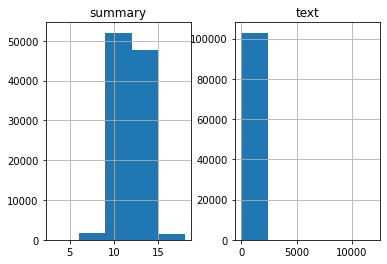

In [11]:
graph_df= pd.DataFrame()
graph_df['text']=text_count
graph_df['summary']=summary_count

import matplotlib.pyplot as plt

graph_df.hist(bins = 5)
plt.show()

In [0]:
#Model to summarize the text between 0-50 words for Summary and 0-200 words for Text
max_text_len = 200
max_summary_len = 50

#Select the Summaries and Text between max len defined above
cleaned_text = np.array(pre['cleaned_text'])
cleaned_summary = np.array(pre['cleaned_summary'])

short_text = []
short_summary = []

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
post_pre=pd.DataFrame({'text':short_text,'summary':short_summary})

In [13]:
post_pre.head(2)

,text,summary
0,saurav kant an alumnus of upgrad and iiit-b pg...,_START_ upgrad learner switches to career in m...
1,kunal shah credit card bill payment platform c...,_START_ delhi techie wins free food from swigg...


In [0]:
#Add sostok(start of sentence token) and eostok(end of sentence token)
post_pre['summary'] = post_pre['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [15]:
post_pre.head(2)

,text,summary
0,saurav kant an alumnus of upgrad and iiit-b pg...,sostok _START_ upgrad learner switches to care...
1,kunal shah credit card bill payment platform c...,sostok _START_ delhi techie wins free food fro...


In [0]:
# Get the train/test split package from sklearn for preparing our dataset to
# train and test the model with
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(post_pre['text']),np.array(post_pre['summary']),test_size=0.3,random_state=0,shuffle=True)

In [17]:
# Let's tokenize the text to get the vocab count
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [0]:
# Prepare a tokenizer on training data for reviews
x_tokenizer = Tokenizer(num_words=5000) 
x_tokenizer.fit_on_texts(list(x_tr))

# Convert text sequences into integer sequences (i.e one-hot encodeing all the words)
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

# Padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

# Size of vocabulary ( +1 for padding token)
x_voc   =  len(x_tokenizer.word_index) + 1

In [0]:
# Prepare a tokenizer for reviews on testing data
y_tokenizer = Tokenizer(num_words=5000) 
y_tokenizer.fit_on_texts(list(y_tr))

# Convert text sequences into integer sequences (i.e one hot encode the text in Y)
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

# Padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

# Size of vocabulary
y_voc  =   len(y_tokenizer.word_index) +1

In [0]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [0]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [0]:

from numpy import array
from numpy import asarray
from numpy import zeros

#Import GloVe word embeddings
# download file form here: https://www.kaggle.com/terenceliu4444/glove6b100dtxt

embeddings_dictionary = dict()
glove_file = open('/content/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

#Updating the dictionary with the pre-trained GloVe embeddings.
embedding_matrix = zeros((x_voc, 100))
for word, index in x_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [23]:
from tensorflow.keras import backend as K 
import gensim
from numpy import *
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

print("Size of vocabulary from the w2v model = {}".format(x_voc))

K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim, weights=[embedding_matrix], trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.5,recurrent_dropout=0.5)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.5,recurrent_dropout=0.5)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.5,recurrent_dropout=0.5)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using 'encoder_states' as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.5,recurrent_dropout=0.5)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Size of vocabulary from the w2v model = 72001
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 100)     7200100     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 200, 300), ( 481200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
________________________________________________

In [0]:
model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [26]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=10,batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/10
543/543 [==============================] - 1484s 3s/step - loss: 1.6633 - accuracy: 0.8113 - val_loss: 1.2656 - val_accuracy: 0.8346
Epoch 2/10
543/543 [==============================] - 1466s 3s/step - loss: 1.2468 - accuracy: 0.8346 - val_loss: 1.2172 - val_accuracy: 0.8362
Epoch 3/10
543/543 [==============================] - 1463s 3s/step - loss: 1.2059 - accuracy: 0.8364 - val_loss: 1.1806 - val_accuracy: 0.8381
Epoch 4/10
543/543 [==============================] - 1475s 3s/step - loss: 1.1698 - accuracy: 0.8383 - val_loss: 1.1494 - val_accuracy: 0.8397
Epoch 5/10
543/543 [==============================] - 1463s 3s/step - loss: 1.1390 - accuracy: 0.8399 - val_loss: 1.1229 - val_accuracy: 0.8416
Epoch 6/10
543/543 [==============================] - 1467s 3s/step - loss: 1.1132 - accuracy: 0.8413 - val_loss: 1.1015 - val_accuracy: 0.8428
Epoch 7/10
543/543 [==============================] - 1466s 3s/step - loss: 1.0900 - accuracy: 0.8425 - val_loss: 1.0805 - val_accuracy:

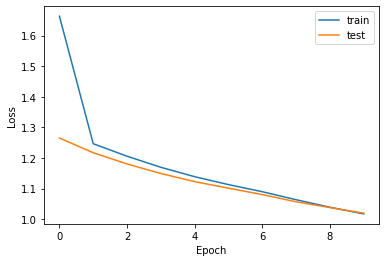

In [27]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.xlabel('Epoch')
pyplot.ylabel('Loss')
pyplot.legend()
pyplot.show()

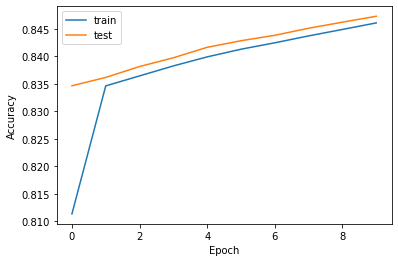

In [29]:
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.xlabel('Epoch')
pyplot.ylabel('Accuracy')
pyplot.legend()
pyplot.show()

In [0]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [0]:
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [0]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [0]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [36]:
for i in range(0,100):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: karnataka cm hd kumaraswamy on monday said that the state government was formed under circumstances and he couldn do magic to change things immediately the coalition government will survive and work he added the cm was reacting to various issues raised by mlas including projects and illegal sand mining among others 
Original summary: start k taka govt made under odd can do cm end 
Predicted summary:  start us prez kovind to be in india end


Review: a 45 year old woman in bihar was gangraped on the banks of the ganga river when she had gone for on monday the accused dragged her out and took turns raping her as the other one shot video which was circulated on whatsapp in the video the woman is seen asking them to consider the of ganga 
Original summary: start 45 yr old woman gangraped by men while in ganga river end 
Predicted summary:  start man held for raping minor girl in delhi end


Review: dera chief gurmeet ram rahim singh has in video appealed to his followers to leave h

In [41]:
#saving the model on the disk

# serialize model to JSON
model_json = model.to_json()
with open("3_Project_2_TT_1dconv_reg.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("3_Project_2_TT_1dconv_reg.h5")
print("Saved model to disk")

Saved model to disk


In [40]:
from tensorflow.keras.models import model_from_json

# load json and create model
json_file = open('3_Project_2_TT_1dconv_reg.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("3_Project_2_TT_1dconv_reg.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
score = loaded_model.evaluate([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:], verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 84.73%
